# <center> **Predicting survival on the Titanic with Machine Learning models**

# <center> **Abstract**

In this notebook, I aim to find which of five pre-chosen machine learning algorithms performs best in the task of predicting the survival status of passengers on the Titanic. The algorithms compared are Random Forest, kNN, Stochastic Gradient Descent, Logistic Regression, and Support Vector Machines. After inspecting the data, the methodology of the algorithms are reviewed, and the results of the implementations are finally presented. The algorithm that performed the best in my implementation
was the Random Forest algorithm, with an average accuracy of 81.59%. Whether this can be generalized to the task as a whole can however not be concluded.


# **1. Introduction**

The data used to train the five machine learning algorithms is from a Kaggle competition called ’Titanic - Machine Learning
from Disaster’, and it hold the details of 891 passengers on board and our target variable: whether they survived or not. The objective for each model is to predict the survival of a remaining 418 passengers in a test set where this target variable is unknown. Our goal is ultimately to find which of the five chosen models performs the best at this task, based on their respective accuracy, precision, recall, and F-score.

**Initialization**

In [162]:
# Loading packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn # visualization
import matplotlib.pyplot as plt # visualization

# Algorithms

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

# **2. Data inspection**

The data provided in the competition is two files: train.csv, and test.csv. The train.csv file - our training data set - lists 891 passengers along with 12 features for each. The most notable features are the passengers’ name, age, sex, cabin
class, and our target variable: whether they survived or not (a ”1” denoting that the passenger survived, and a ”0” denoting that they died). The test.csv file - our testing data set - lists the remaining 418 passengers in the passenger records of
the Titanic, along with all the same features except that of survival, which is the value we will attempt to predict.

We inspect the first 5 rows of the training data:

In [163]:
train_data = pd.read_csv('train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


And the first 5 rows of the testing data:

In [164]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# **3. Data visualization**

In order to find what features will be relevant in our predictions, it is useful to analyze and visualize some aspects of the data. First of all, one could assume that the survival rate of females on board is higher than that of males. When
analyzing the ”Sex” and ”Survived” features in our training data set, we indeed
find that whereas approximately 74 percent of the female passengers survived,
only about 19 percent of the male passengers did:

Female survival rate: 0.7420382165605095
Male survival rate: 0.18890814558058924


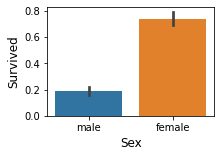

In [165]:
# Survival rate of females vs males
print("Female survival rate:", train_data["Survived"][train_data["Sex"] == 'female'].value_counts(True)[1])
print("Male survival rate:", train_data["Survived"][train_data["Sex"] == 'male'].value_counts(True)[1])

# Drawing the bar plot of survival w.r.t sex
fig = plt.figure(figsize = (3, 2))
ax = seaborn.barplot(x="Sex", y="Survived", data=train_data)

ax.set_ylabel("Survived", fontsize=12)
ax.set_xlabel("Sex", fontsize=12)
plt.show()

Second of all, newborns and children were most likely prioritized on the ship,
and their survival rate should as such be higher. Grouping the passengers into
age groups, we indeed find that the survival rate is the highest for infants, and
steadily declines with the increase of age:

Infant survival rate: 0.625
Child survival rate: 0.5555555555555556
Teenager survival rate: 0.42857142857142855
Adult survival rate: 0.3887884267631103
Senior survival rate: 0.22727272727272727


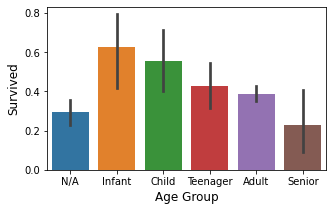

In [166]:
# Fill null values
train_data["Age"] = train_data["Age"].fillna(-0.5)
test_data["Age"] = test_data["Age"].fillna(-0.5)

# Creating bins (converting the numeric 'age' variable to categorical)
bins = [-1, 0, 2, 12, 18, 60, np.inf]
labels = ['N/A', 'Infant', 'Child', 'Teenager', 'Adult', 'Senior']
train_data['AgeGroup'] = pd.cut(train_data["Age"], bins, labels = labels)
test_data['AgeGroup'] = pd.cut(test_data["Age"], bins, labels = labels)

# Survival rate by age group
print('Infant survival rate:', train_data["Survived"][train_data["AgeGroup"] == 'Infant'].value_counts(True)[1])
print('Child survival rate:', train_data["Survived"][train_data["AgeGroup"] == 'Child'].value_counts(True)[1])
print('Teenager survival rate:', train_data["Survived"][train_data["AgeGroup"] == 'Teenager'].value_counts(True)[1])
print('Adult survival rate:', train_data["Survived"][train_data["AgeGroup"] == 'Adult'].value_counts(True)[1])
print('Senior survival rate:', train_data["Survived"][train_data["AgeGroup"] == 'Senior'].value_counts(True)[1])

# Drawing the bar plot of age vs survival
fig = plt.figure(figsize = (5, 3))
ax = seaborn.barplot(x="AgeGroup", y="Survived", data=train_data)
ax.set_ylabel("Survived", fontsize=12)
ax.set_xlabel("Age Group", fontsize=12)
plt.show()

Another feature that likely had great importance is what ticket class the passengers were travelling in. It is rather probable that the passengers who travelled
1st class had a higher survival rate than those who travelled 2nd or 3rd. Drawing a plot, we indeed find a negative linear relationship between survival rate
and ticket class. While over 62 percent of the passengers travelling in 1st class
survived, this number drops down to 47 percent for 2nd class passengers and 24
percent for those in 3rd class:

Survival rate of passengers in 1st class: 0.6296296296296297
Survival rate of passengers in 2nd class: 0.47282608695652173
Survival rate of passengers in 3rd class: 0.24236252545824846


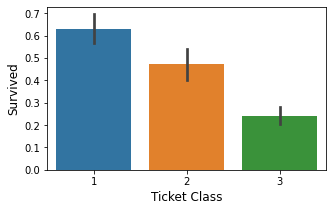

In [167]:
# Survival rate by Pclass
print("Survival rate of passengers in 1st class:", train_data["Survived"][train_data["Pclass"] == 1].value_counts(True)[1])
print("Survival rate of passengers in 2nd class:", train_data["Survived"][train_data["Pclass"] == 2].value_counts(True)[1])
print("Survival rate of passengers in 3rd class:", train_data["Survived"][train_data["Pclass"] == 3].value_counts(True)[1])

# Drawing a bar plot of Pclass surival rates
fig = plt.figure(figsize = (5, 3))
ax = seaborn.barplot(x="Pclass", y="Survived", data=train_data)
ax.set_ylabel("Survived", fontsize=12)
ax.set_xlabel('Ticket Class', fontsize=12)
plt.show()

Although there are more features we could include from the data set, it
could be argued that sex, age, and ticket class are the three most important
and independent ones. Fare, for example, should broadly be measuring the
same thing as the ticket class, and including it might as such not provide much
further insight for the classifiers. In fact, adding more features could potentially
do more harm than good, since the more features a model has, the higher is the
risk of overfitting. As such, we will only look at the Ticket Class, Sex, and Age for our training.

In [168]:
# Select features
features = ["Pclass", "Sex", "Age"]

# One-hot encoding
X_train = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

# **4. Evaluation**

There are many evaluation metrics for machine learning methods. Apart from accuracy, which is the amount of correct predictions out of all the predictions, we will furthermore consider the confusion matrix. The confusion matrix is a common evaluation metric when working with machine learning classifiers, and it is essentially a representation of the true positives $TP$, false negatives $FN$, false positives $FP$, and true negatives $TN$. With these values, we can calculate the precision, recall, and subsequently the F-score: 

<center>$Precision=\frac{\text { TP }}{\text { TP }+\text { FP }}$
<center>$Recall=\frac{\text { TP }}{\text { TP }+\text { FN }}$
<center>$F-score=\frac{2\times Precision \times Recall}{\text { Precision }+\text { Recall }}$
    
In words, the precision can be described as the frequency with which positive identifications were actually correct, while recall is the frequency with which actual positives were correctly identified. The F-score is intended to combine the precision and recall to obtain a single measure of search effectiveness.
    
All algorithms were tested on the given dataset which was already split into approximately 70% training data and 30% testing data. The performance of all models was furthermore estimated with a 10-fold cross validation.

**Random Forest**

Accuracy: 81.373% (std: 2.159%, var:0.047%)


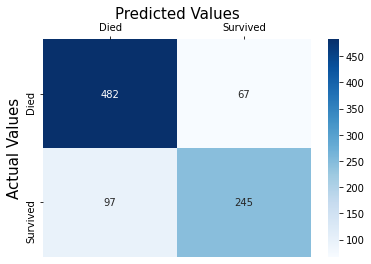

In [169]:
# Overall accuracy with 10-fold cross validation
k_fold = model_selection.KFold(n_splits=10)
random_forest = RandomForestClassifier()
results = model_selection.cross_val_score(random_forest, X_train, Y_train, cv=k_fold, scoring='accuracy')
print("Accuracy: %.3f%% (std: %.3f%%, var:%.3f%%)" % (results.mean()*100.0, results.std()*100.0, results.var()*100.0))


# Confusion Matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=10)
random_forest_cm = confusion_matrix(Y_train, predictions)

cm_heatmap = seaborn.heatmap(random_forest_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
cm_heatmap.xaxis.set_ticks_position('top')
cm_heatmap.xaxis.set_label_position('top')
cm_heatmap.set_xlabel('Predicted Values', fontsize = 15)
cm_heatmap.set_ylabel('Actual Values', fontsize = 15)
plt.show()

In [170]:
# Precision, Recall, F-score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:", recall_score(Y_train, predictions))
print("F-score:", f1_score(Y_train, predictions))

Precision: 0.7852564102564102
Recall: 0.716374269005848
F-score: 0.7492354740061162


In [171]:
# Save results for barplots later
rf_acc = results.mean()*100.0
rf_std = results.std()*100.0
rf_prec = precision_score(Y_train, predictions)*100
rf_rec = recall_score(Y_train, predictions)*100
rf_f = f1_score(Y_train, predictions)*100

**kNN**

The performance of the kNN algorithm is greatly affected by the choice of $k$. While setting $k$ too low results in a classifier of low bias and high variance, setting $k$ too high will conversely lead to a model of low variance but high bias. I will find the optimal $k$ by using cross-validated grid search, with 5-fold cross-validation over a parameter grid where the range of $k$ is 1 to 25:

{'n_neighbors': 3}


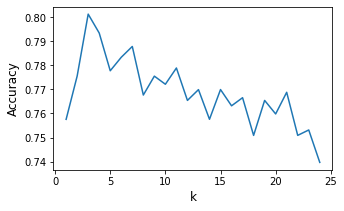

In [172]:
# Create a kNN model
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

# Use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

# Fit model to data
knn_gscv.fit(X_train, Y_train)

# Check top performing n_neighbors value
print(knn_gscv.best_params_)

# Plot
fig = plt.figure(figsize = (5, 3))
plt.plot(knn_gscv.cv_results_['param_n_neighbors'].data, knn_gscv.cv_results_['mean_test_score'])
plt.xlabel("k", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.show()

It seems that the best value for $k$ (in terms of accuracy) is 3, so this is the value I will use for training the kNN.

Accuracy: 78.567% (std: 3.473%, var:0.121%)


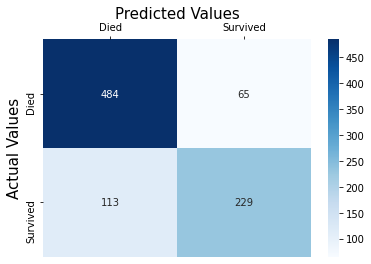

In [173]:
# Overall accuracy with 10-fold cross validation
k_fold = model_selection.KFold(n_splits=10)
kNN = KNeighborsClassifier(n_neighbors = 3)
results = model_selection.cross_val_score(kNN, X_train, Y_train, cv=k_fold, scoring='accuracy')
print("Accuracy: %.3f%% (std: %.3f%%, var:%.3f%%)" % (results.mean()*100.0, results.std()*100.0, results.var()*100.0))


# Confusion Matrix
predictions = cross_val_predict(kNN, X_train, Y_train, cv=10)
kNN_cm = confusion_matrix(Y_train, predictions)

cm_heatmap = seaborn.heatmap(kNN_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
cm_heatmap.xaxis.set_ticks_position('top')
cm_heatmap.xaxis.set_label_position('top')
cm_heatmap.set_xlabel('Predicted Values', fontsize = 15)
cm_heatmap.set_ylabel('Actual Values', fontsize = 15)
plt.show()

In [174]:
# Precision, Recall, F-score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:", recall_score(Y_train, predictions))
print("F-score:", f1_score(Y_train, predictions))

Precision: 0.7789115646258503
Recall: 0.6695906432748538
F-score: 0.720125786163522


In [175]:
# Save results for barplots later
knn_acc = results.mean()*100.0
knn_std = results.std()*100.0
knn_prec = precision_score(Y_train, predictions)*100
knn_rec = recall_score(Y_train, predictions)*100
knn_f = f1_score(Y_train, predictions)*100

**Stochastic Gradient Descent**

Accuracy: 69.693% (std: 10.110%, var:1.022%)


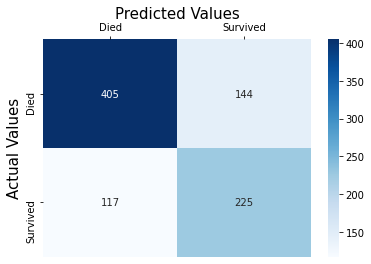

In [176]:
# Overall accuracy with 10-fold cross validation
k_fold = model_selection.KFold(n_splits=10)
sgd = linear_model.SGDClassifier()
results = model_selection.cross_val_score(sgd, X_train, Y_train, cv=k_fold, scoring='accuracy')
print("Accuracy: %.3f%% (std: %.3f%%, var:%.3f%%)" % (results.mean()*100.0, results.std()*100.0, results.var()*100.0))


# Confusion Matrix
predictions = cross_val_predict(sgd, X_train, Y_train, cv=10)
sgd_cm = confusion_matrix(Y_train, predictions)

cm_heatmap = seaborn.heatmap(sgd_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
cm_heatmap.xaxis.set_ticks_position('top')
cm_heatmap.xaxis.set_label_position('top')
cm_heatmap.set_xlabel('Predicted Values', fontsize = 15)
cm_heatmap.set_ylabel('Actual Values', fontsize = 15)
plt.show()

In [177]:
# Precision, Recall, F-score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:", recall_score(Y_train, predictions))
print("F-score:", f1_score(Y_train, predictions))

Precision: 0.6097560975609756
Recall: 0.6578947368421053
F-score: 0.6329113924050632


In [178]:
# Save results for barplots later
sgd_acc = results.mean()*100.0
sgd_std = results.std()*100.0
sgd_prec = precision_score(Y_train, predictions)*100
sgd_rec = recall_score(Y_train, predictions)*100
sgd_f = f1_score(Y_train, predictions)*100

**Logistic Regression**

Accuracy: 77.660% (std: 4.268%, var:0.182%)


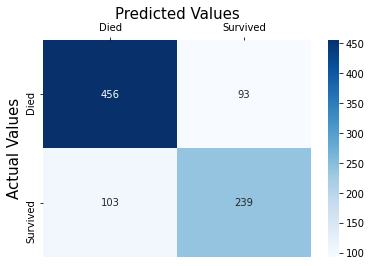

In [179]:
# Overall accuracy with 10-fold cross validation
k_fold = model_selection.KFold(n_splits=10)
logreg = LogisticRegression()
results = model_selection.cross_val_score(logreg, X_train, Y_train, cv=k_fold, scoring='accuracy')
print("Accuracy: %.3f%% (std: %.3f%%, var:%.3f%%)" % (results.mean()*100.0, results.std()*100.0, results.var()*100.0))


# Confusion Matrix
predictions = cross_val_predict(logreg, X_train, Y_train, cv=10)
logreg_cm = confusion_matrix(Y_train, predictions)

cm_heatmap = seaborn.heatmap(logreg_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
cm_heatmap.xaxis.set_ticks_position('top')
cm_heatmap.xaxis.set_label_position('top')
cm_heatmap.set_xlabel('Predicted Values', fontsize = 15)
cm_heatmap.set_ylabel('Actual Values', fontsize = 15)
plt.show()

In [180]:
# Precision, Recall, F-score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:", recall_score(Y_train, predictions))
print("F-score:", f1_score(Y_train, predictions))

Precision: 0.7198795180722891
Recall: 0.6988304093567251
F-score: 0.7091988130563798


In [181]:
# Save results for barplots later
lr_acc = results.mean()*100.0
lr_std = results.std()*100.0
lr_prec = precision_score(Y_train, predictions)*100
lr_rec = recall_score(Y_train, predictions)*100
lr_f = f1_score(Y_train, predictions)*100

**Support Vector Machines**

Accuracy: 78.111% (std: 3.544%, var:0.126%)


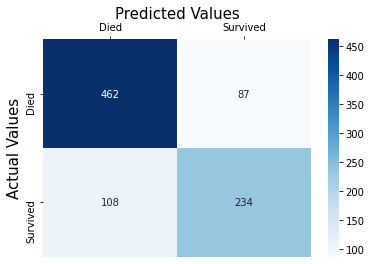

In [182]:
# Overall accuracy with 10-fold cross validation
k_fold = model_selection.KFold(n_splits=10)
linear_svc = LinearSVC(dual=False)
results = model_selection.cross_val_score(linear_svc, X_train, Y_train, cv=k_fold, scoring='accuracy')
print("Accuracy: %.3f%% (std: %.3f%%, var:%.3f%%)" % (results.mean()*100.0, results.std()*100.0, results.var()*100.0))

# Confusion Matrix
predictions = cross_val_predict(linear_svc, X_train, Y_train, cv=10)
svc_cm = confusion_matrix(Y_train, predictions)

cm_heatmap = seaborn.heatmap(svc_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
cm_heatmap.xaxis.set_ticks_position('top')
cm_heatmap.xaxis.set_label_position('top')
cm_heatmap.set_xlabel('Predicted Values', fontsize = 15)
cm_heatmap.set_ylabel('Actual Values', fontsize = 15)
plt.show()

In [183]:
# Precision, Recall, F-score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:", recall_score(Y_train, predictions))
print("F-score:", f1_score(Y_train, predictions))

Precision: 0.7289719626168224
Recall: 0.6842105263157895
F-score: 0.7058823529411765


In [184]:
# Save results for barplots later
svm_acc = results.mean()*100.0
svm_std = results.std()*100.0
svm_prec = precision_score(Y_train, predictions)*100
svm_rec = recall_score(Y_train, predictions)*100
svm_f = f1_score(Y_train, predictions)*100

# **Conclusion**

In the error bar plot below, we can see that the algorithm that performed the best in terms of average accuracy was the Random Forest model.

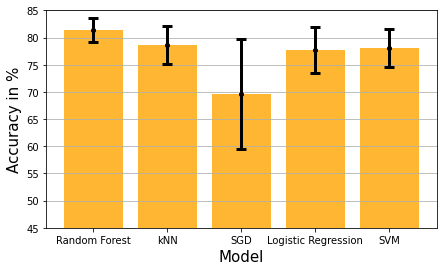

In [185]:
# Standard Deviation Error Bar

fig = plt.figure(figsize = (7, 4))

plt.errorbar( ['Random Forest', 'kNN', 'SGD', 'Logistic Regression', 'SVM'], [rf_acc, knn_acc, sgd_acc, lr_acc, svm_acc], yerr=[rf_std, knn_std, sgd_std, lr_std, svm_std], fmt='o', color='Black', elinewidth=3,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.bar(['Random Forest', 'kNN', 'SGD', 'Logistic Regression', 'SVM'], [rf_acc, knn_acc, sgd_acc, lr_acc, svm_acc],tick_label = ['Random Forest', 'kNN', 'SGD', 'Logistic Regression', 'SVM'], align='center', alpha=0.8, color='orange', ecolor='black', capsize=10)# Bar plot
plt.xlabel('Model', fontsize = 15) # Label on X axis
plt.ylabel('Accuracy in %', fontsize = 15) # Label on Y axis
axes = plt.gca()
axes.set_ylim([45,85])
axes.yaxis.grid(True)
plt.show()

In the bar plot below, we can also see how the algorithms performed in the areas of precision,
recall, and F-score. The Random Forest algorithm outperformed the other
algorithms in all three categories.

                 Model  Precision     Recall    F-score
0        Random Forest  78.525641  71.637427  74.923547
1                  kNN  77.891156  66.959064  72.012579
2                  SGD  60.975610  65.789474  63.291139
3  Logistic Regression  71.987952  69.883041  70.919881
4                  SVM  72.897196  68.421053  70.588235


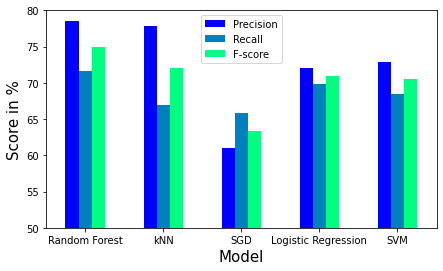

In [186]:
# Precision, Recall, F-score Barplot

# Create data
df = pd.DataFrame([['Random Forest', rf_prec, rf_rec, rf_f], ['kNN', knn_prec, knn_rec, knn_f], ['SGD', sgd_prec, sgd_rec, sgd_f],
                   ['Logistic Regression', lr_prec, lr_rec, lr_f], ['SVM', svm_prec, svm_rec, svm_f]],
                  columns=['Model', 'Precision', 'Recall', 'F-score'])
# View data
print(df)
  
# Plot grouped bar chart
ax = df.plot(x='Model',
        kind='bar',
        stacked=False,
        ylim=[50, 80],
        figsize=(7,4),
        colormap='winter',
        rot=0)

ax.set_ylabel("Score in %", fontsize=15)
ax.set_xlabel('Model', fontsize=15)
plt.show()

As such, we can conclude that the model which performed the best in this
particular implementation was the Random Forest algorithm. However, we cannot make any claims on whether this is the case in general for this classification
task, as the standard deviations - especially that of the SGD - indicate that
repeating the experiment could result in another algorithm taking the lead. For
future research, it would be interesting to investigate why the performance of
the SGD indeed fluctuates so greatly. In terms of improvements to this research,
it would have been optimal to compute the feature importance, rather than intuitively decide which features to train the classifiers on. Moreover, one should
further explore hyperparameter tuning options for all chosen algorithms, rather
than only tune the kNN as was done in this notebook.